<h1>Create initial images to be used in feather tutorial</h1>

In [1]:
# import pkg_resources, os
# casa_data_dir = pkg_resources.resource_filename("casadata", "__data__")
# rc_file = open(os.path.expanduser("~/.casarc"), "a+")  # append mode
# rc_file.write("\nmeasures.directory: " + casa_data_dir)
# rc_file.close()

In [2]:
# download base images
from toolviper.utils.data import download

download("feather_sim_sd_c1_pI.im")
download("feather_sim_vla_c1_pI.im")

[2025-09-02 11:41:35,711]     INFO    viperlog:  Downloading from [cloudflare] .... 


 Download List            
 ───────────────────────── 
  feather_sim_sd_c1_pI.im

Output()

[2025-09-02 11:41:39,270]     INFO    viperlog:  Downloading from [cloudflare] .... 


 Download List             
 ────────────────────────── 
  feather_sim_vla_c1_pI.im

Output()

In [3]:
# from graphviper.dask.client import local_client
# viper_client = local_client(cores=4, memory_limit="4GB")

# import dask
# dask.config.set(scheduler="synchronous")
# dask.config.set(scheduler="threads")

<h2>Inputs to be specified by user</h2>

In [4]:
# ra, dec size, should not exceed 4096 x 4096
imsize = [1024, 1024]

# number of channels
nchan = 16

# currently, there is only one polarization and it is I

In [5]:
from xradio.image.image import (
    make_empty_sky_image
)
import numpy as np
rad_per_arcsec = np.pi/180/3600
skel_xds = make_empty_sky_image(
    phase_center=[0.6, -0.2],
    image_size=imsize,
    cell_size=[15*rad_per_arcsec, 15*rad_per_arcsec],
    chan_coords=np.linspace(1.4e9, 1.5e9, nchan),
    pol_coords=["I"],
    time_coords=[0],
)
# does not have dim beam_param
skel_xds

<xarray.Dataset> Size: 17MB
Dimensions:          (time: 1, frequency: 16, polarization: 1, l: 1024,
                      m: 1024, beam_param: 3)
Coordinates:
  * time             (time) float64 8B 0.0
  * frequency        (frequency) float64 128B 1.4e+09 1.407e+09 ... 1.5e+09
    velocity         (frequency) float64 128B 1.1e+07 9.626e+06 ... -9.626e+06
  * polarization     (polarization) <U1 4B 'I'
  * l                (l) float64 8kB 0.03723 0.03716 ... -0.03709 -0.03716
  * m                (m) float64 8kB -0.03723 -0.03716 ... 0.03709 0.03716
    right_ascension  (l, m) float64 8MB 0.6383 0.6383 0.6383 ... 0.5623 0.5623
    declination      (l, m) float64 8MB -0.2371 -0.237 ... -0.1628 -0.1627
  * beam_param       (beam_param) <U5 60B 'major' 'minor' 'pa'
Data variables:
    *empty*
Attributes:
    data_groups:  {'base': {}}
    direction:    {'reference': {'attrs': {'frame': 'fk5', 'type': 'sky_coord...

In [6]:
from xradio.image import read_image

sel_dict = {}
if imsize[0] < 4096:
    blc = 2048 - imsize[0]//2
    l_slice = slice(blc, blc + imsize[0])
    sel_dict["l"] = l_slice
if imsize[1] < 4096:
    blc = 2048 - imsize[1]//2
    m_slice = slice(blc, blc + imsize[1])
    sel_dict["m"] = m_slice
xds_sd_temp = read_image("feather_sim_sd_c1_pI.im").isel(sel_dict)
print("xds_sd_temp sky shape", xds_sd_temp.SKY.shape)
print("xds_sd_temp beam shape", xds_sd_temp.BEAM.shape)
print("xds_sd_temp beam values", xds_sd_temp.BEAM.values)
xds_sd_temp

[2025-09-02 11:41:45,760]     INFO    viperlog:  J2000 found as system reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 
Successful readonly open of default-locked table feather_sim_sd_c1_pI.im: 1 columns, 1 rows
[2025-09-02 11:41:45,768]     INFO    viperlog:  J2000 found as native reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 
xds_sd_temp sky shape (1, 1, 1, 1024, 1024)
xds_sd_temp beam shape (1, 1, 1, 3)
xds_sd_temp beam values [[[[0.00407243 0.00407243 0.        ]]]]


<xarray.Dataset> Size: 21MB
Dimensions:          (time: 1, frequency: 1, polarization: 1, l: 1024, m: 1024,
                      beam_param: 3)
Coordinates:
  * time             (time) float64 8B 5.154e+04
  * frequency        (frequency) float64 8B 1.414e+09
  * polarization     (polarization) <U1 4B 'I'
    velocity         (frequency) float64 8B 1.352e+06
  * l                (l) float64 8kB 0.03723 0.03716 ... -0.03709 -0.03716
  * m                (m) float64 8kB -0.03723 -0.03716 ... 0.03709 0.03716
    right_ascension  (l, m) float64 8MB 0.03727 0.03727 0.03727 ... 6.246 6.246
    declination      (l, m) float64 8MB -0.03724 -0.03717 ... 0.0371 0.03717
  * beam_param       (beam_param) <U5 60B 'major' 'minor' 'pa'
Data variables:
    SKY              (time, frequency, polarization, l, m) float32 4MB dask.array<chunksize=(1, 1, 1, 1024, 1024), meta=np.ndarray>
    BEAM             (time, frequency, polarization, beam_param) float64 24B dask.array<chunksize=(1, 1, 1, 3), meta=np.ndarray>
Attributes:
    direction:  {'reference': {'attrs': {'frame': 'fk5', 'type': 'sky_coord',...

In [7]:
xds_int_temp = read_image("feather_sim_vla_c1_pI.im").isel(sel_dict)
#xds_int_temp
print("xds_int_temp sky shape", xds_int_temp.SKY.shape)
print("xds_int_temp beam shape", xds_int_temp.BEAM.shape)
print("xds_int_temp beam values", xds_int_temp.BEAM.values)
xds_int_temp

[2025-09-02 11:41:46,980]     INFO    viperlog:  J2000 found as system reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 
Successful readonly open of default-locked table feather_sim_vla_c1_pI.im: 1 columns, 1 rows
[2025-09-02 11:41:47,003]     INFO    viperlog:  J2000 found as native reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 
xds_int_temp sky shape (1, 1, 1, 1024, 1024)
xds_int_temp beam shape (1, 1, 1, 3)
xds_int_temp beam values [[[[ 0.00031759  0.00031237 -0.05489258]]]]


<xarray.Dataset> Size: 21MB
Dimensions:          (time: 1, frequency: 1, polarization: 1, l: 1024, m: 1024,
                      beam_param: 3)
Coordinates:
  * time             (time) float64 8B 5.876e+04
  * frequency        (frequency) float64 8B 1.414e+09
  * polarization     (polarization) <U1 4B 'I'
    velocity         (frequency) float64 8B 2.119e+05
  * l                (l) float64 8kB 0.03723 0.03716 ... -0.03709 -0.03716
  * m                (m) float64 8kB -0.03723 -0.03716 ... 0.03709 0.03716
    right_ascension  (l, m) float64 8MB 0.03727 0.03727 0.03727 ... 6.246 6.246
    declination      (l, m) float64 8MB -0.03724 -0.03717 ... 0.0371 0.03717
  * beam_param       (beam_param) <U5 60B 'major' 'minor' 'pa'
Data variables:
    SKY              (time, frequency, polarization, l, m) float32 4MB dask.array<chunksize=(1, 1, 1, 1024, 1024), meta=np.ndarray>
    BEAM             (time, frequency, polarization, beam_param) float64 24B dask.array<chunksize=(1, 1, 1, 3), meta=np.ndarray>
Attributes:
    direction:  {'reference': {'attrs': {'frame': 'fk5', 'type': 'sky_coord',...

In [8]:
import dask.array as da
import xarray as xr
dm = skel_xds.sizes
sky_da_zeros = da.zeros(
    [
        dm["time"], dm["frequency"],
        dm["polarization"], dm["l"], dm["m"]
    ], dtype=np.float32
)
sky_dims = list(skel_xds.dims)
sky_dims.remove("beam_param")
coords = ["time", "frequency", "polarization", "l", "m"]
sky_coords = {}
for c in coords:
    sky_coords[c] = skel_xds[c]
sky_xa_zeros = xr.DataArray(
    data=sky_da_zeros,
    coords=sky_coords,
    dims=sky_dims
)
sky_xa_zeros

<xarray.DataArray 'zeros_like-5d27a3e62e8dfb188c45d11b1b6d6202' (time: 1,
                                                                 frequency: 16,
                                                                 polarization: 1,
                                                                 l: 1024,
                                                                 m: 1024)> Size: 67MB
dask.array<zeros_like, shape=(1, 16, 1, 1024, 1024), dtype=float32, chunksize=(1, 16, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) float64 8B 0.0
  * frequency     (frequency) float64 128B 1.4e+09 1.407e+09 ... 1.5e+09
  * polarization  (polarization) <U1 4B 'I'
  * l             (l) float64 8kB 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m             (m) float64 8kB -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716

In [9]:
beam_da_zeros = da.zeros(
    [
        dm["time"], dm["frequency"],
        dm["polarization"], dm["beam_param"]
    ], dtype=np.float32
)
beam_dims = ["time", "frequency", "polarization", "beam_param"]
beam_xa_zeros = xr.DataArray(
    beam_da_zeros.copy(),
    dims=beam_dims,
    coords={k: v for k, v in skel_xds.coords.items() if k in beam_dims + ["velocity"] }
)

beam_xa_zeros

<xarray.DataArray 'zeros_like-cfffd29277ab41e42103e58dc30a3ea1' (time: 1,
                                                                 frequency: 16,
                                                                 polarization: 1,
                                                                 beam_param: 3)> Size: 192B
dask.array<zeros_like, shape=(1, 16, 1, 3), dtype=float32, chunksize=(1, 16, 1, 3), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) float64 8B 0.0
  * frequency     (frequency) float64 128B 1.4e+09 1.407e+09 ... 1.5e+09
    velocity      (frequency) float64 128B 1.1e+07 9.626e+06 ... -9.626e+06
  * polarization  (polarization) <U1 4B 'I'
  * beam_param    (beam_param) <U5 60B 'major' 'minor' 'pa'

In [10]:
import copy
for i in (0, 1):
    xds = copy.deepcopy(skel_xds)
    xds["SKY"] = sky_xa_zeros.copy()
    xds["BEAM"] = beam_xa_zeros.copy()
    for j in range(0, nchan, 16):
        min_chan = j
        max_chan = min(j+16, nchan)
        fx = xds_sd_temp if i == 0 else xds_int_temp
        xds["SKY"][{"frequency": slice(min_chan, max_chan)}] = (
            fx["SKY"].values
        )
        xds["SKY"].attrs = {"units": "Jy/beam"}
        print(f"xds {id(xds)}")
        xds["BEAM"][{"frequency": slice(min_chan, max_chan)}] = (
            fx["BEAM"].values
        )
        xds["BEAM"].attrs = {"units": "rad"}
    if i == 0:
        xds_sd = xds
    else:
        xds_int = xds
xds_int.BEAM.values

xds 5348723792
xds 5348728400


array([[[[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]],

        [[ 0.00031759,  0.00031237, -0.05489258]]]], dtype=float32)

In [11]:
bytes_in_dtype = {'float32':4,'double':8,'complex':16}

#chunking_dims_sizes = {'frequency':int_xds["sky"].sizes['frequency']}
#memory_singleton_chunk = 3*np.product(np.array(list(chunking_dims_sizes.values())))
xds_sd['SKY'].sizes['frequency']

singleton_chunk_sizes = dict(xds_sd['SKY'].sizes) 
del singleton_chunk_sizes['frequency'] #Remove dimensions that will be chuncked on.
fudge_factor = 1.1
n_images_in_memory = 3.0
memory_singleton_chunk = n_images_in_memory*np.prod(np.array(list(singleton_chunk_sizes.values())))*fudge_factor*bytes_in_dtype[str(xds_sd['SKY'].dtype)]/(1024**3)


memory_singleton_chunk

np.float64(0.012890625000000001)

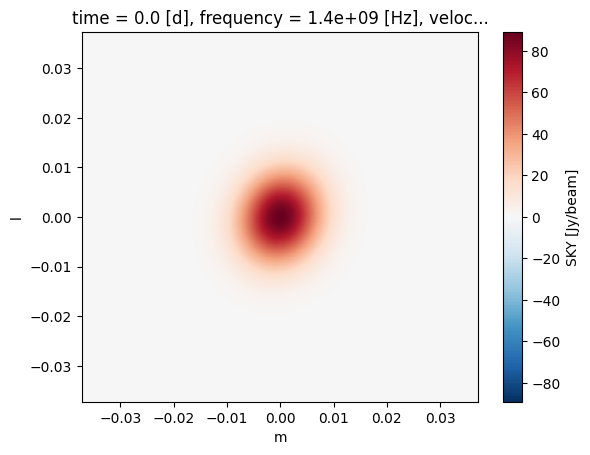

In [12]:
xds_sd["SKY"].sel(polarization="I").isel(frequency=0, time=0).plot()

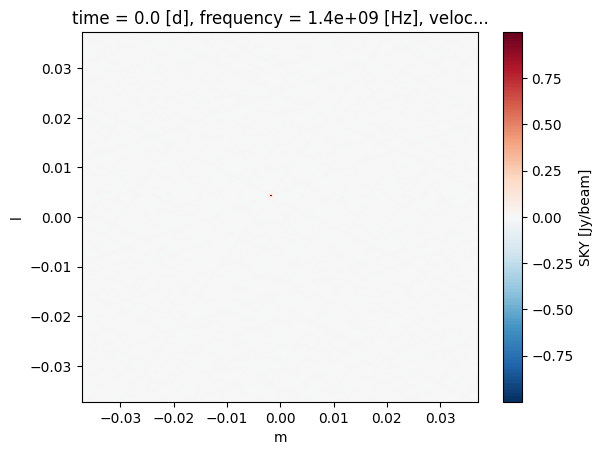

In [13]:
# This is a point source, so may not be obvious
# in this plot. It's a small dot near the center.
xds_int["SKY"].sel(polarization="I").isel(frequency=0, time=0).plot()

In [14]:
# These are the input images for the next step

import os, shutil

from xradio.image import write_image
for xds, outfile in zip([xds_sd, xds_int], ["sd.zarr", "int.zarr"]):
    if os.path.exists(outfile):
        shutil.rmtree(outfile)
    write_image(xds, outfile, "zarr")
    print(f"Wrote {outfile}")
# xds_int
xds_sd

Wrote sd.zarr
Wrote int.zarr


<xarray.Dataset> Size: 84MB
Dimensions:          (time: 1, frequency: 16, polarization: 1, l: 1024,
                      m: 1024, beam_param: 3)
Coordinates:
  * time             (time) float64 8B 0.0
  * frequency        (frequency) float64 128B 1.4e+09 1.407e+09 ... 1.5e+09
    velocity         (frequency) float64 128B 1.1e+07 9.626e+06 ... -9.626e+06
  * polarization     (polarization) <U1 4B 'I'
  * l                (l) float64 8kB 0.03723 0.03716 ... -0.03709 -0.03716
  * m                (m) float64 8kB -0.03723 -0.03716 ... 0.03709 0.03716
    right_ascension  (l, m) float64 8MB 0.6383 0.6383 0.6383 ... 0.5623 0.5623
    declination      (l, m) float64 8MB -0.2371 -0.237 ... -0.1628 -0.1627
  * beam_param       (beam_param) <U5 60B 'major' 'minor' 'pa'
Data variables:
    SKY              (time, frequency, polarization, l, m) float32 67MB dask.array<chunksize=(1, 16, 1, 1024, 1024), meta=np.ndarray>
    BEAM             (time, frequency, polarization, beam_param) float32 192B dask.array<chunksize=(1, 16, 1, 3), meta=np.ndarray>
Attributes:
    data_groups:  {'base': {}}
    direction:    {'reference': {'attrs': {'frame': 'fk5', 'type': 'sky_coord...

In [15]:
# You now have the required input images. Run feather_tutorial_v2.ipynb to use them
# to make the final feather image.